In [1]:
import os
os.environ['DJANGO_SETTINGS_MODULE'] = 'ClusterCast.settings'
import test_utils
import django
django.setup()
import sys
sys.path.append("/home/ajp031/StockDeepLearning/ClusterCast/ClusterCast")
from asgiref.sync import sync_to_async
from importlib import reload
import ClusterPipeline.models.ClusterProcessing as cp
import ClusterPipeline.models.SequencePreprocessing as sp
from copy import deepcopy
import numpy as np
from tensorflow.keras.backend import clear_session
from tslearn.metrics import dtw

import random

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f236899f640>
Traceback (most recent call last):
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/usr/remote/apps/anaconda/2023.03-acet116/lib/python3.10/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
2024-03-25 19:48:03.722173: I tensorflow/core/pl

In [ ]:
reload(test_utils)

In [ ]:
group_ids = [63]
groups = await test_utils.extract_cluster_groups(group_ids)

In [ ]:
clusters = await test_utils.get_all_clusters(groups)

cur_group = groups[0]

In [ ]:
cluster_of_interest_id = 601
cluster_of_interest = [cluster for cluster in clusters if cluster.id == cluster_of_interest_id][0]

In [ ]:
features = groups[0].group_params.training_features

features

In [ ]:
X_train, y_train, X_test, y_test = cluster_of_interest.get_3d_array()


In [ ]:
print(X_test[0, :,0])
print(cluster_of_interest.test_seq_elements[0].seq_x[:,0])
print(cluster_of_interest.test_seq_elements[0].start_date)

In [ ]:
print(X_test[0, :,50])
print(cluster_of_interest.test_seq_elements[-1].seq_x[:,50])
print(cluster_of_interest.test_seq_elements[-1].start_date)

In [ ]:
print(features)

In [ ]:
target_features = [] 
# target_features += ['pctChgclose{}_target'.format(i) for i in range(-14, 0) ]
# target_features += ['pctChgclose-0_target']
target_features += ['pctChgclose+{}_target'.format(i) for i in range(1, 26) ]

training_features = []
training_features = random.sample(features, 20)
# training_features += ['pctChgvolume', 'pctChgclose','pctDiff+ema50_close','pctDiff+ema10_close','deriv+ema10' ]
# training_features += ['pctChgvolume', 'pctChgclose','pctDiff+ema50_close', 'opHi', 'hiCl', 'hiLo', 'loCl' ]
# training_features = ['pctChgclose', 'pctChgvolume','pctDiff+ema50_close','pctDiff+ema10_close','deriv+ema10', 'pctChgVix','pctDiff+bb_high_close10','pctDiff+bb_low_close10', 'bb_indicator40','pctChgClOp','pctDiff+bb_high_low10','stoch_k','pctDiff+ema10_close' ]
# training_features = "pctDiff+bb_low_close20, pctDiff+bb_high_close10, pctDiff+bb_high_low60, stoch_k, pctChgclose, deriv+sma10, hiLo, rsi10, pctDiff+sma5_sma50, pctDiff+sma10_sma20, deriv+ema20, pctDiff+ema20_ema100, pctDiff+ema30_ema50, deriv+ema30, deriv+sma200, pctDiff+sma50_sma100, pctDiff+sma20_close, opLo, pctChgvolume, pctDiff+bb_low_close60"
# training_features = [item.strip() for item in training_features.split(",")]
print(training_features)
y_feature_sets = cur_group.group_params.y_feature_sets


In [ ]:
# for feature_set in y_feature_sets:
#     print(feature_set)
#     print(type(feature_set))
y_feature_sets = y_feature_sets[:-1]

In [ ]:
reload(test_utils)

In [ ]:
print(target_features)
print(len(target_features))

In [ ]:
y_feature_dict = cur_group.y_feature_dict
X_feature_dict = cur_group.X_feature_dict

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(y_feature_dict)

In [ ]:

X_train_filtered = test_utils.filter_by_features(X_train, training_features, X_feature_dict)
X_test_filtered = test_utils.filter_by_features(X_test, training_features, X_feature_dict)
y_train_filtered = test_utils.filter_y_by_features(y_train, target_features, y_feature_dict)
y_test_filtered = test_utils.filter_y_by_features(y_test, target_features, y_feature_dict)
print(X_train_filtered.shape)
print(y_train_filtered.shape)
print(X_test_filtered.shape)
print(y_test_filtered.shape)

In [ ]:
print(X_train_filtered[25, 0,:])

In [ ]:
print(y_train_filtered[25, :])

In [ ]:
training_model, test_model = test_utils.create_attention_model(input_steps=X_train.shape[1],output_steps=len(target_features),features=len(training_features))


In [ ]:
training_model = test_utils.train_model(training_model, (X_train, y_train, X_test, y_test), training_features, 
                                                   target_features, X_feature_dict, y_feature_dict,
                                                   epochs = 100, batch_size = 20, lr = 0.0005, early_stopping_patience = 15,
                                                   loss = 'huber_loss')

In [ ]:
num_days = 25
attention_model_accuracy, attention_results, predicted_y, attention_weights = test_utils.eval_model(X_test_filtered, y_test_filtered, test_model,num_days)

In [ ]:
print(attention_weights.shape)

In [ ]:
predicted_y_transformed = np.zeros_like(predicted_y)
for i, feature in enumerate(target_features):
    scaler = [feature_set for feature_set in y_feature_sets if feature == feature_set.name][0].scaler
    predicted_y_transformed[:, i] = scaler.inverse_transform(predicted_y[:, i].reshape(-1, 1)).reshape(-1)

In [ ]:
reload(test_utils)
reload(sp)

In [ ]:
print(attention_model_accuracy)

test_utils.visualize_future_distribution(attention_results)

[]


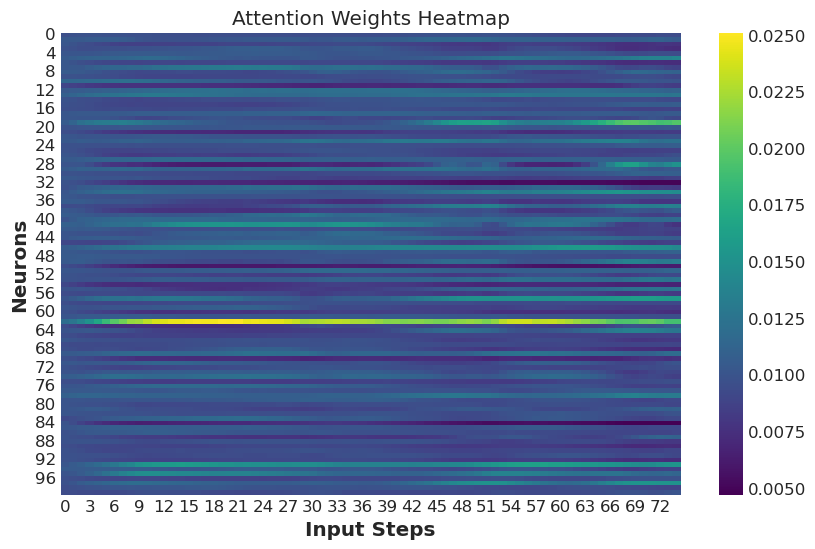

(25,)
25
DatetimeIndex(['2021-09-22'], dtype='datetime64[ns]', freq='C')


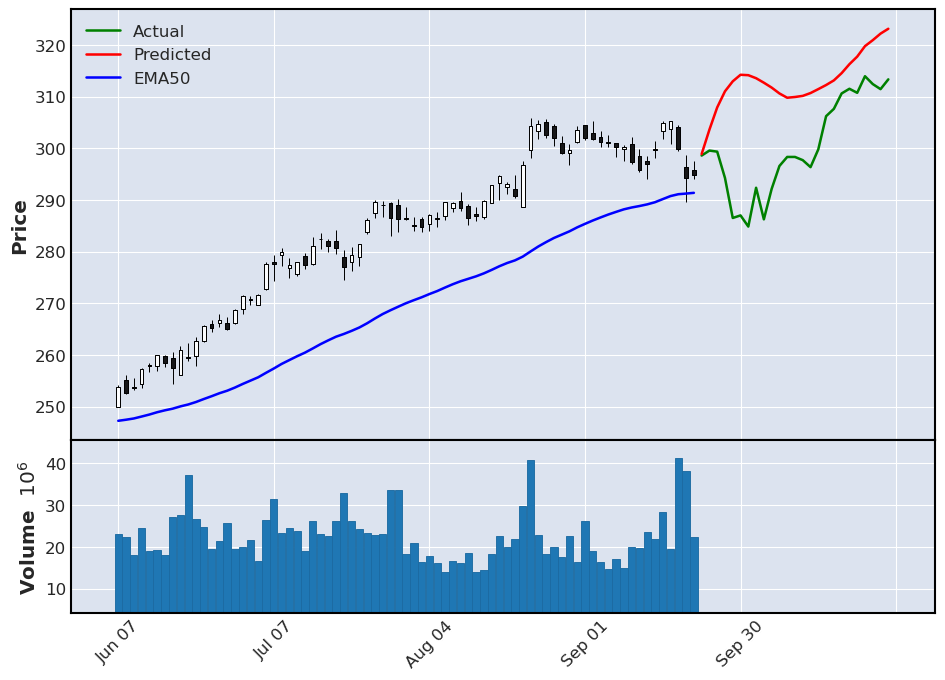

[]


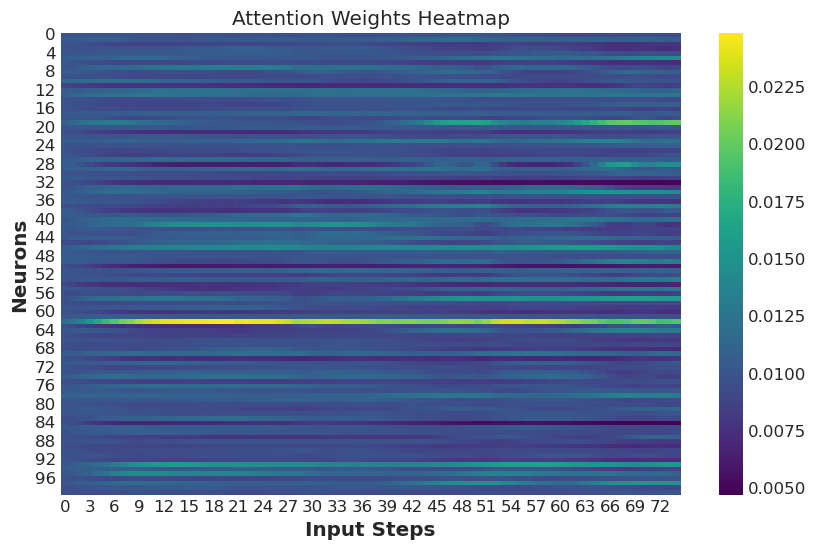

(25,)
25
DatetimeIndex(['2021-09-23'], dtype='datetime64[ns]', freq='C')


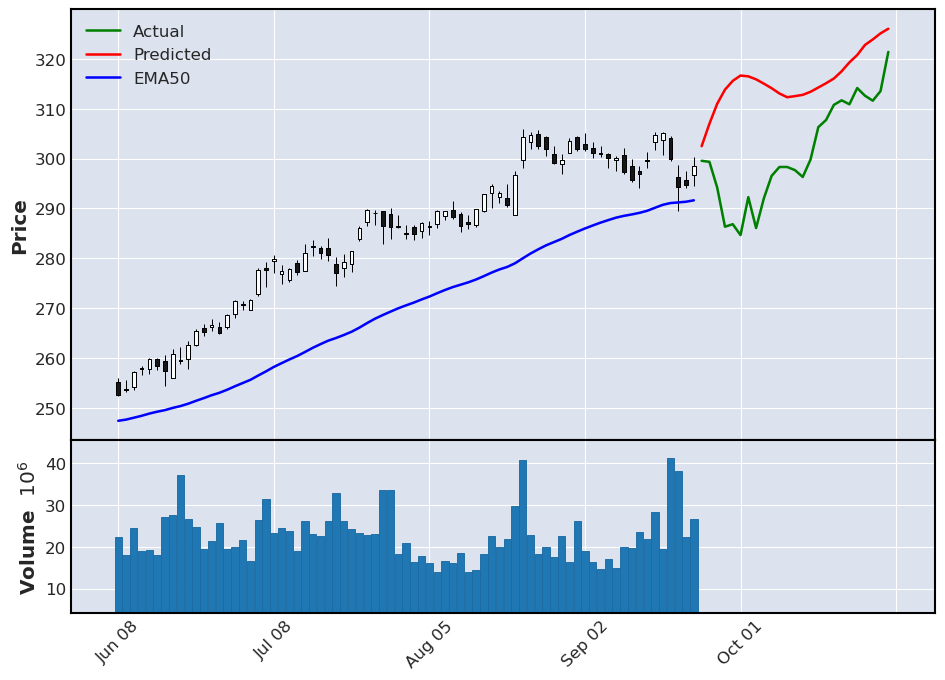

[]


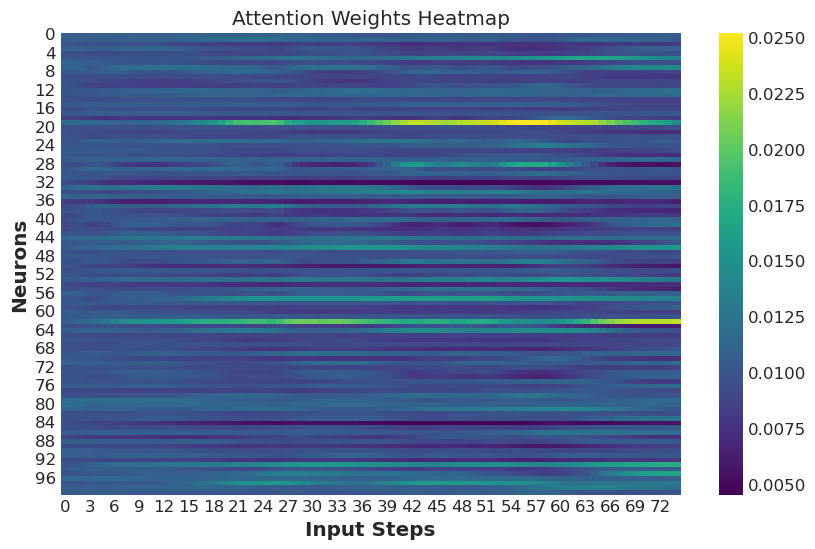

(25,)
25
DatetimeIndex(['2021-10-28'], dtype='datetime64[ns]', freq='C')


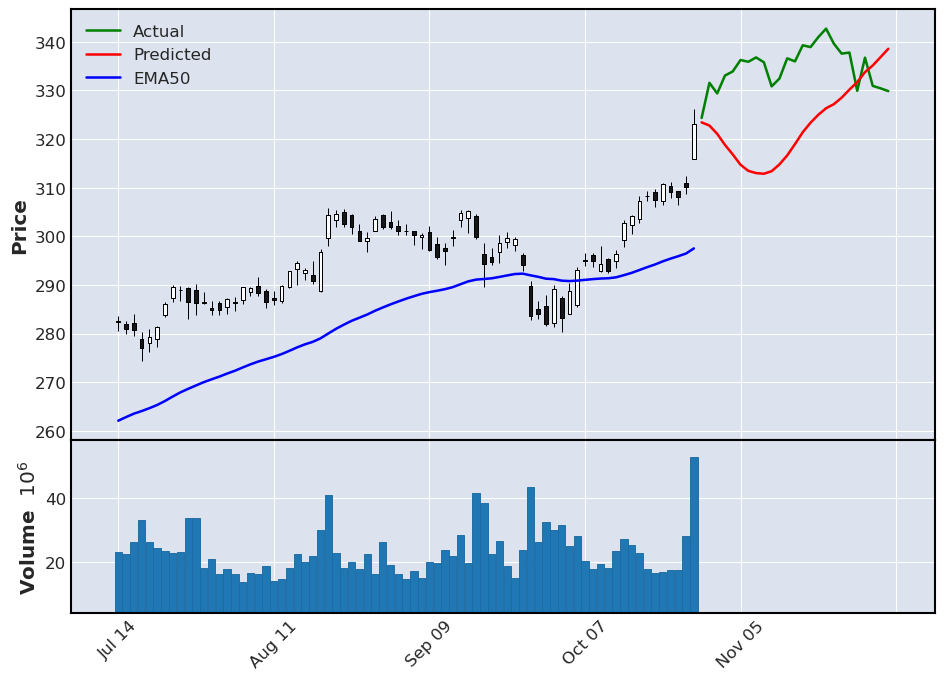

[]


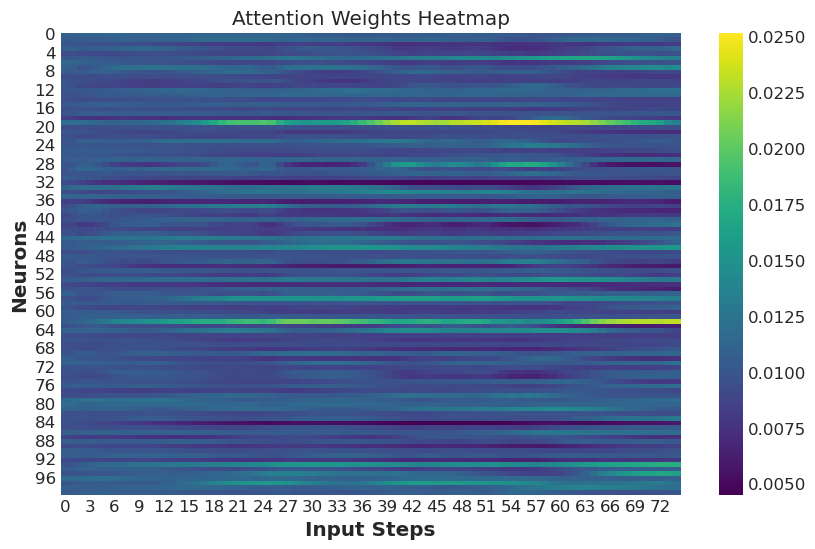

(25,)
25
DatetimeIndex(['2021-10-29'], dtype='datetime64[ns]', freq='C')


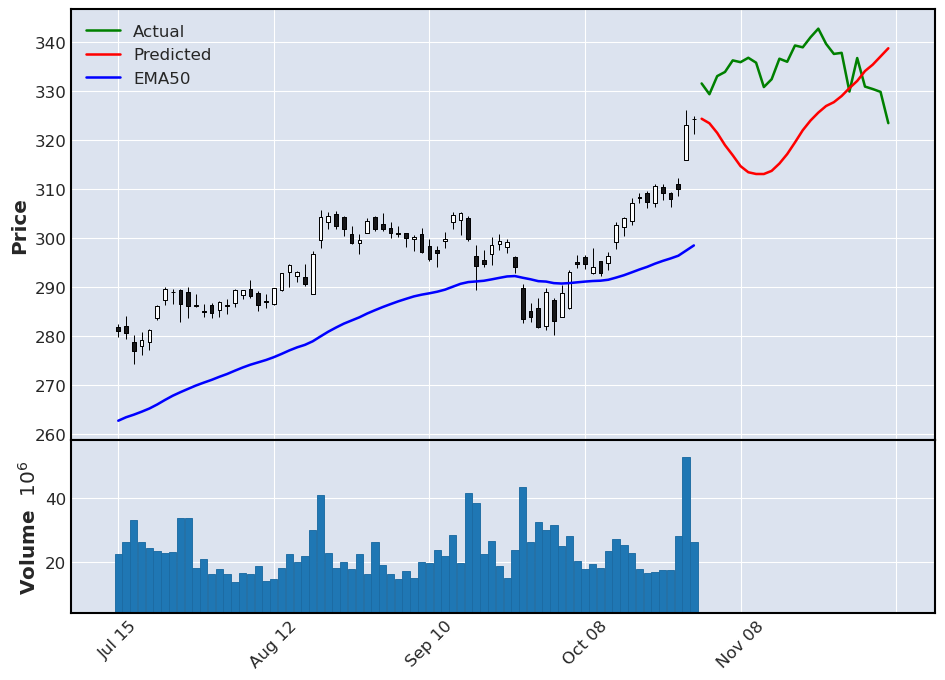

[]


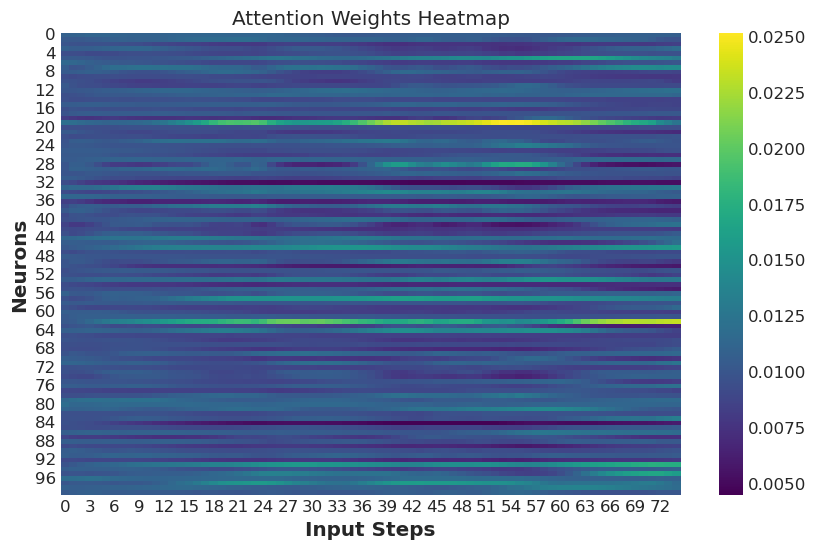

(25,)
25
DatetimeIndex(['2021-11-01'], dtype='datetime64[ns]', freq='C')


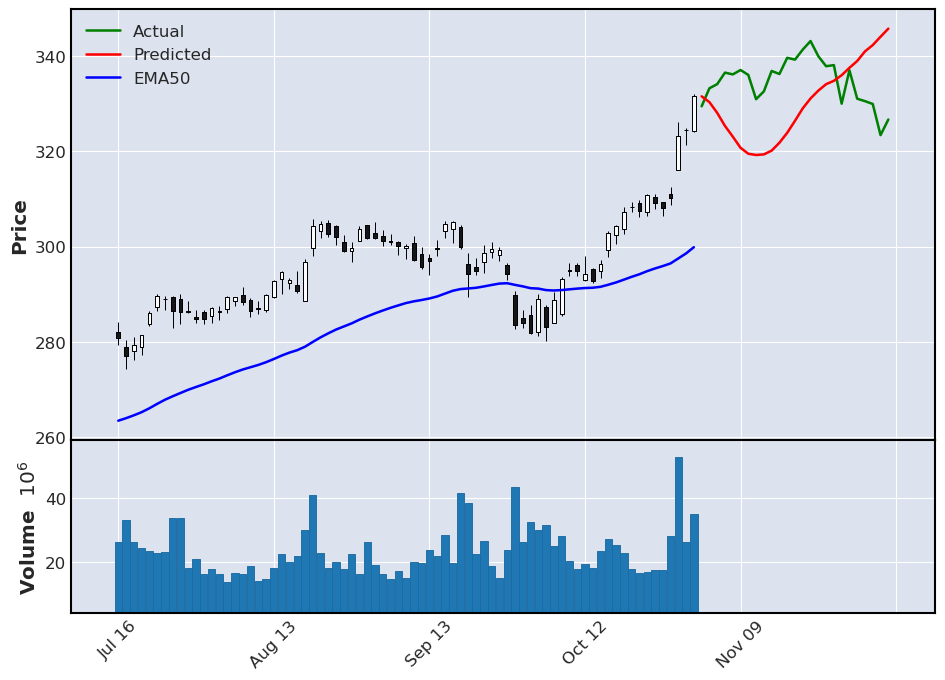

[]


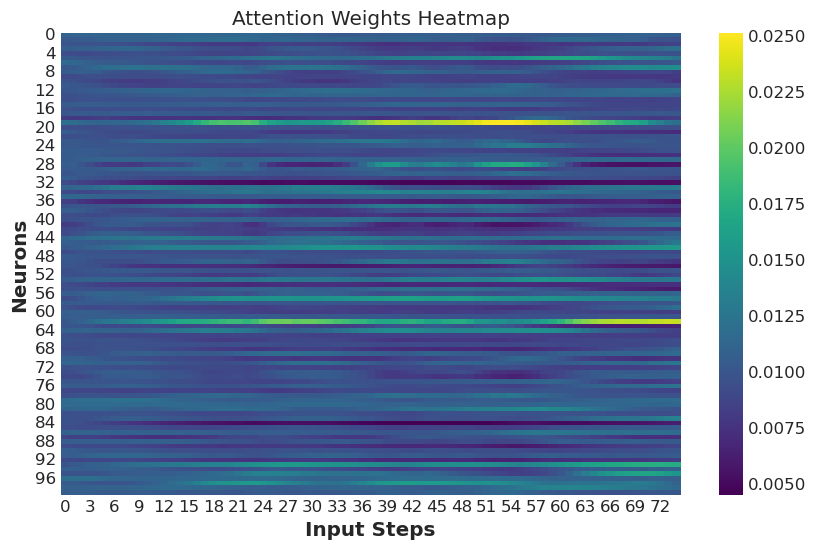

(25,)
25
DatetimeIndex(['2021-11-02'], dtype='datetime64[ns]', freq='C')


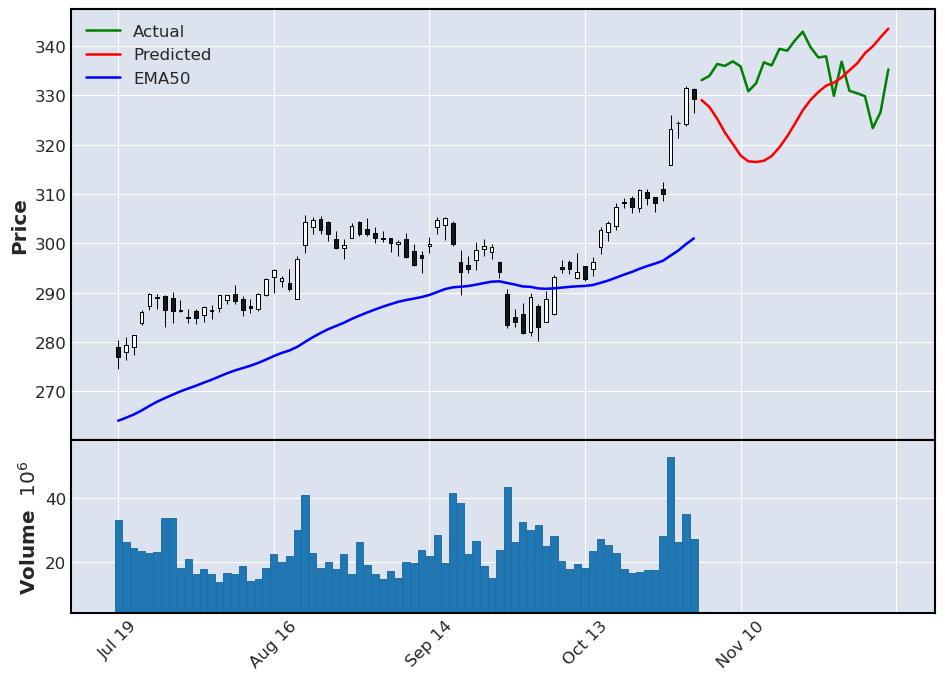

[]


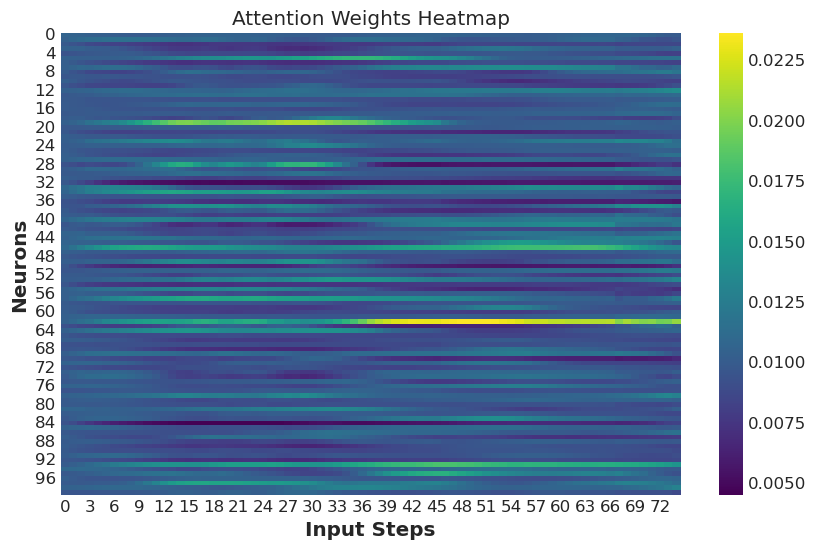

(25,)
25
DatetimeIndex(['2021-12-08', '2021-12-09'], dtype='datetime64[ns]', freq='C')


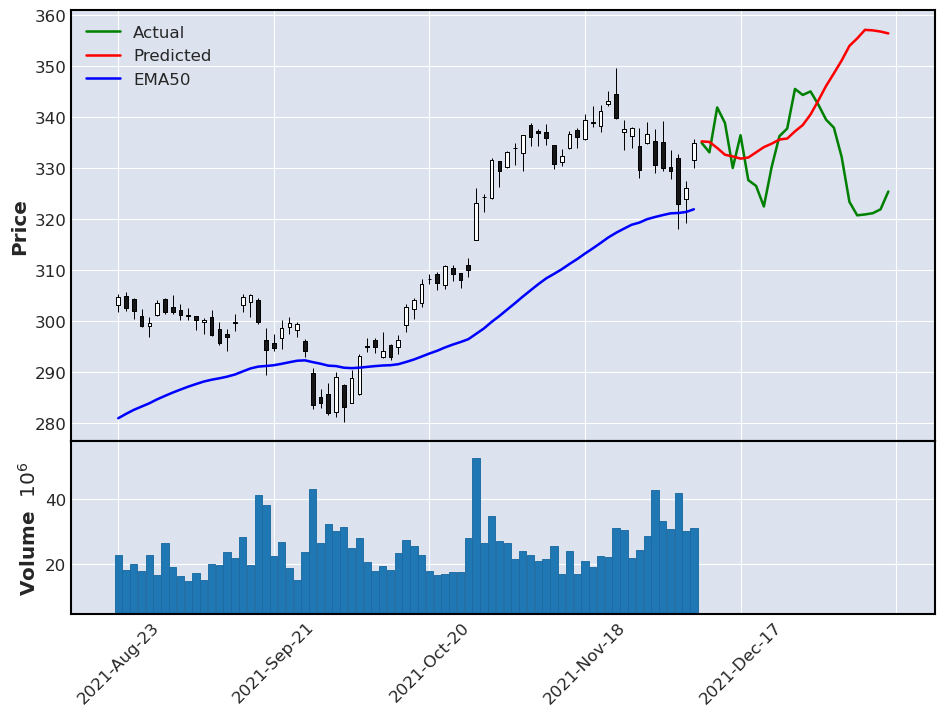

[]


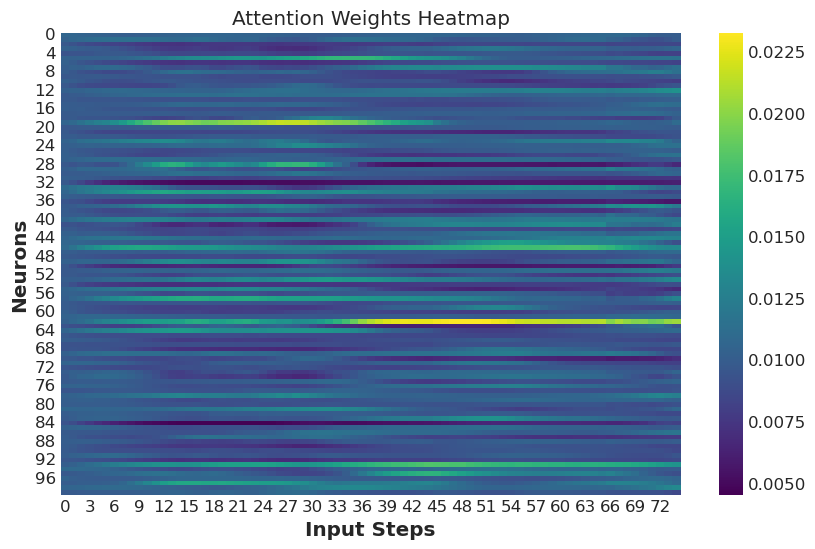

(25,)
25
DatetimeIndex(['2021-12-09', '2021-12-10'], dtype='datetime64[ns]', freq='C')


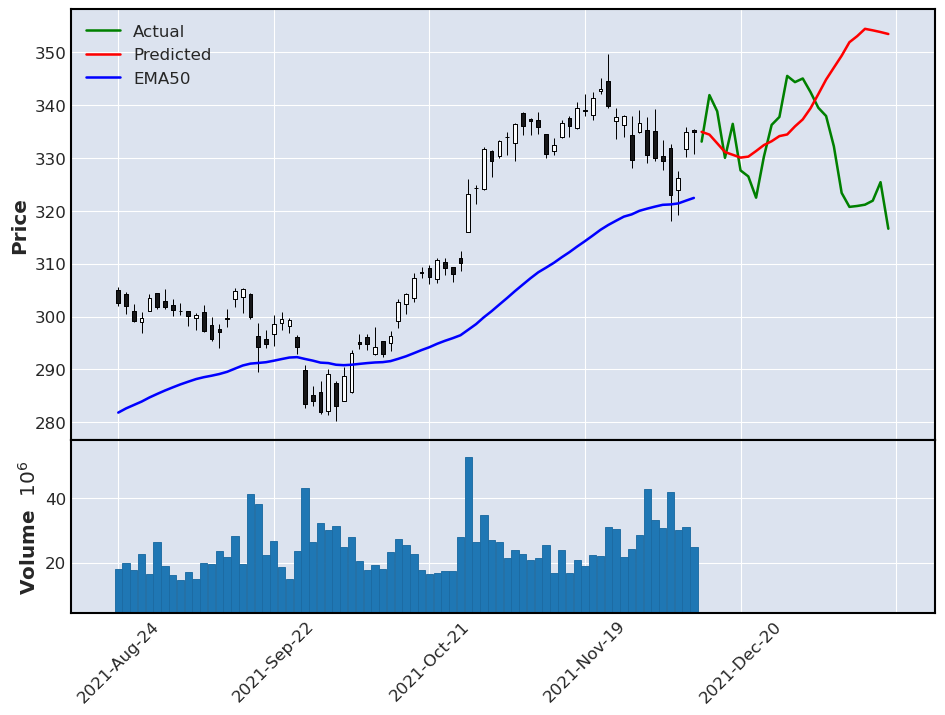

[]


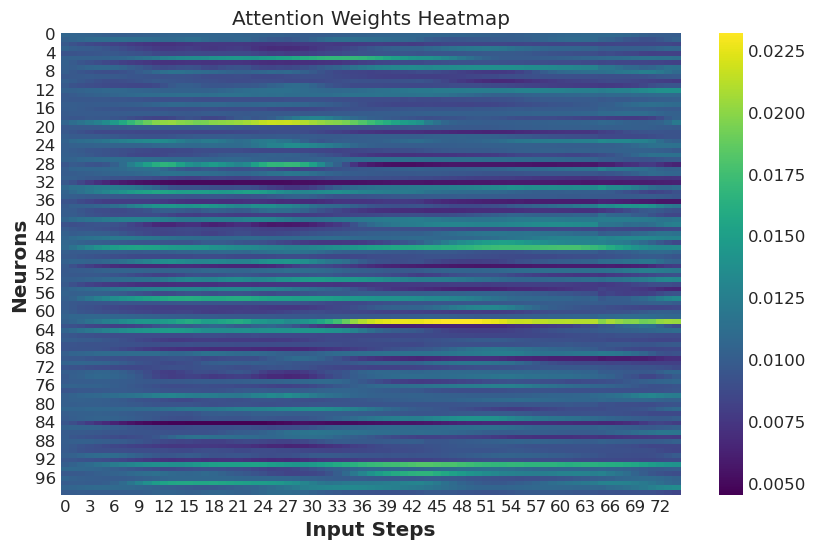

(25,)
25
DatetimeIndex(['2021-12-10', '2021-12-13'], dtype='datetime64[ns]', freq='C')


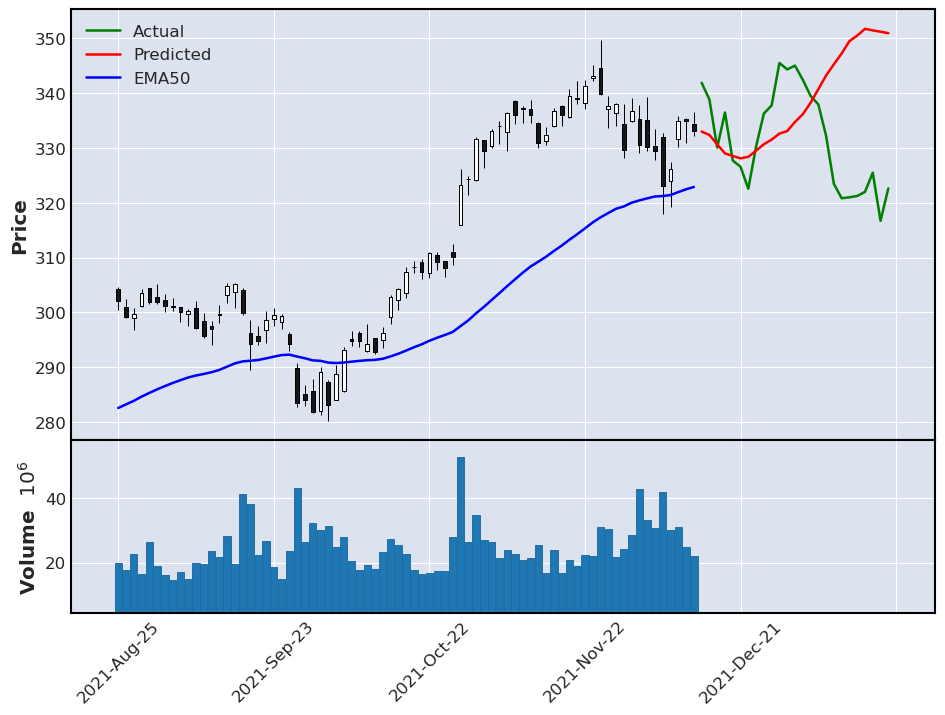

[]


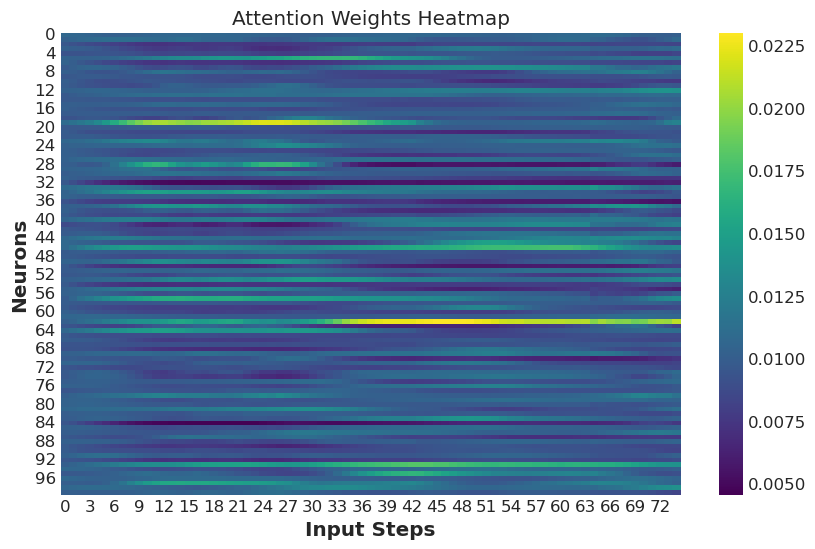

(25,)
25
DatetimeIndex(['2021-12-13', '2021-12-14'], dtype='datetime64[ns]', freq='C')


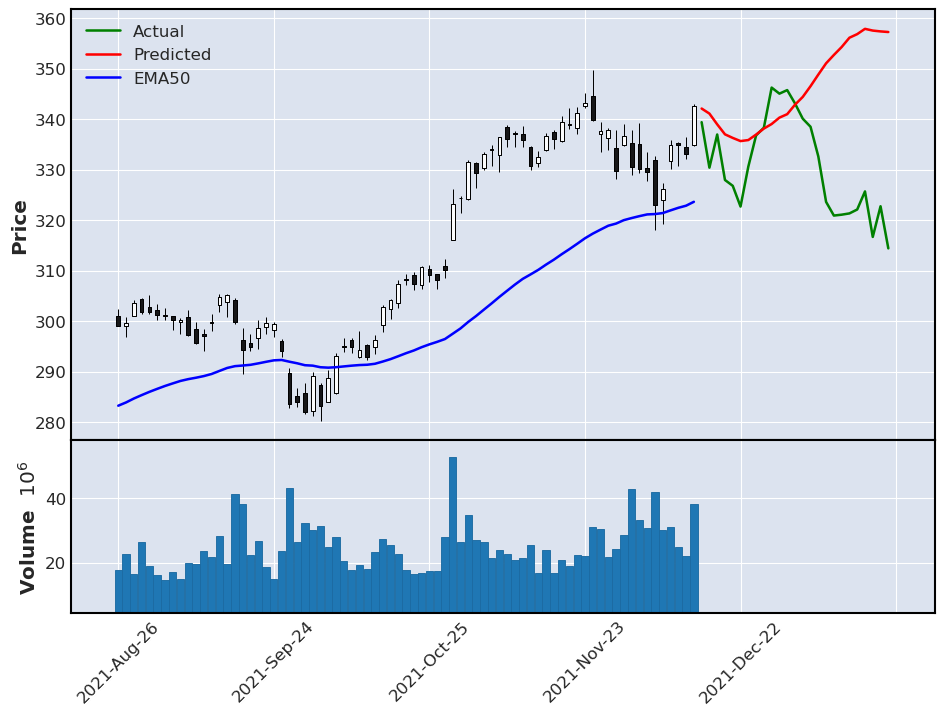

[]


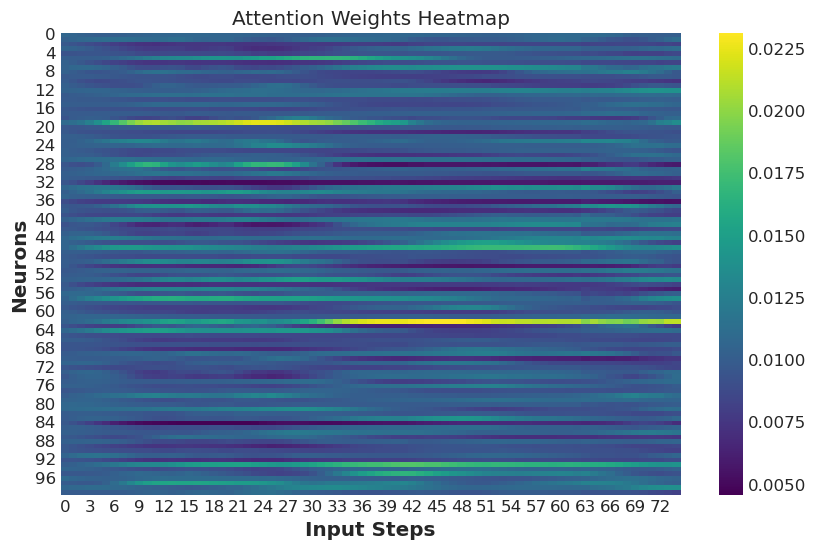

(25,)
25
DatetimeIndex(['2021-12-14', '2021-12-15'], dtype='datetime64[ns]', freq='C')


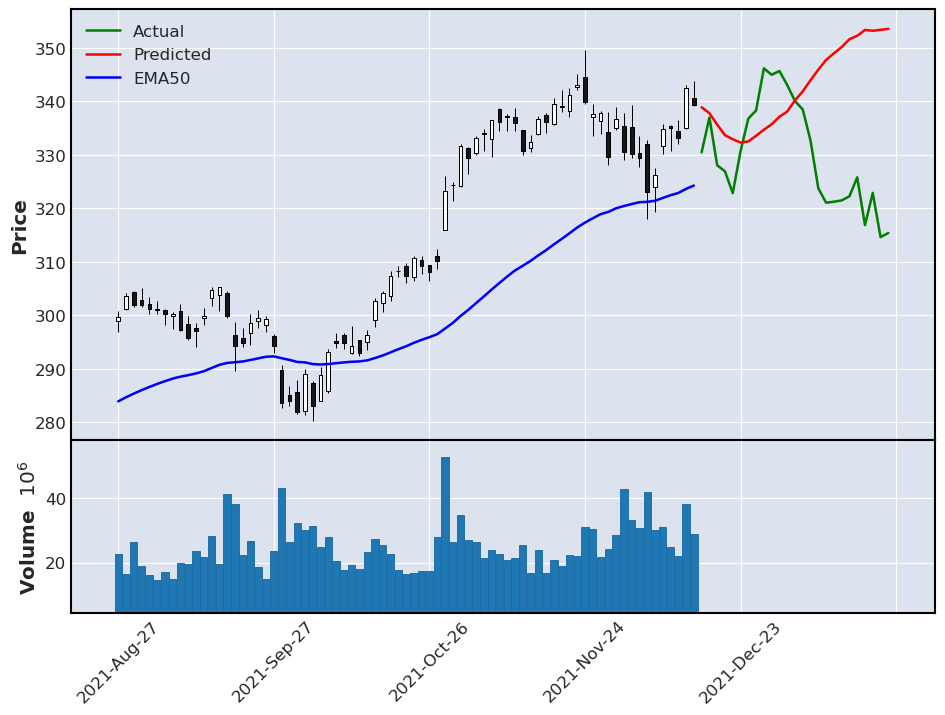

[]


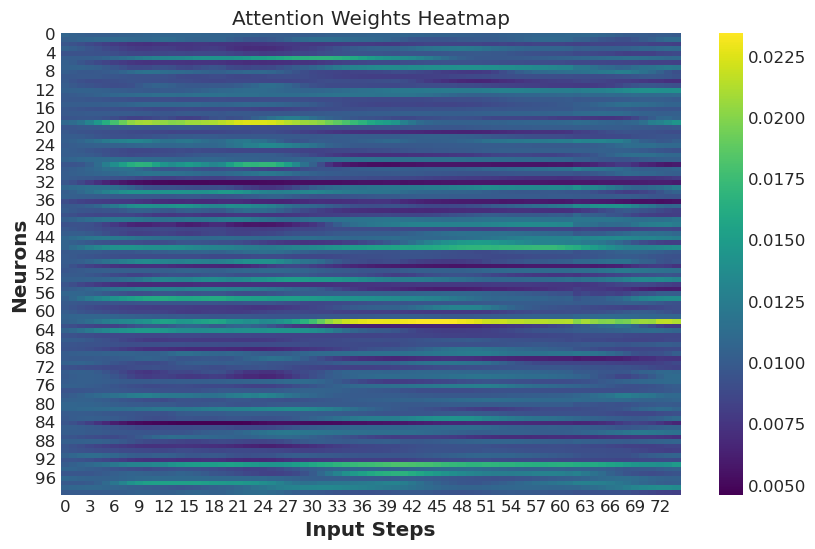

(25,)
25
DatetimeIndex(['2021-12-15', '2021-12-16'], dtype='datetime64[ns]', freq='C')


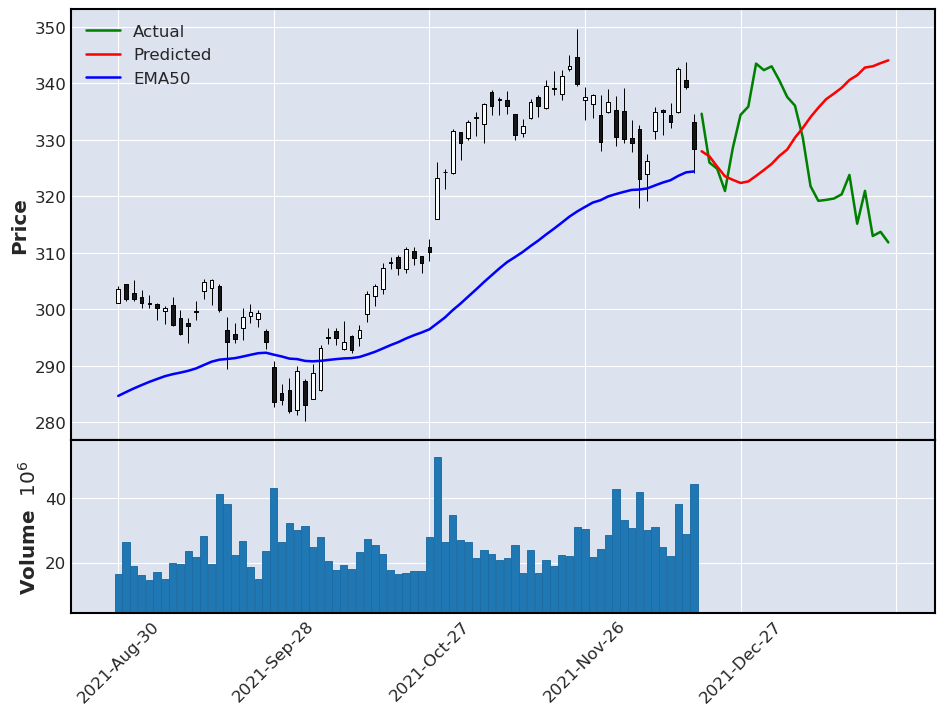

[]


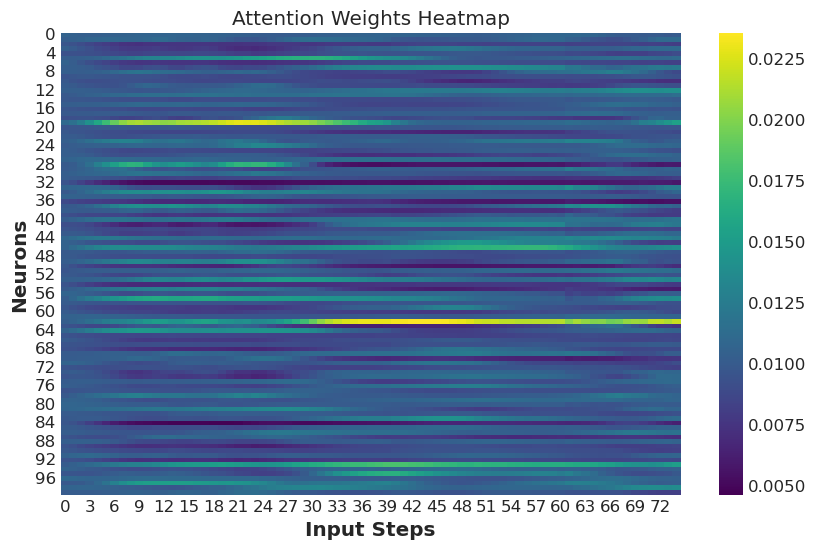

(25,)
25
DatetimeIndex(['2021-12-16', '2021-12-17'], dtype='datetime64[ns]', freq='C')


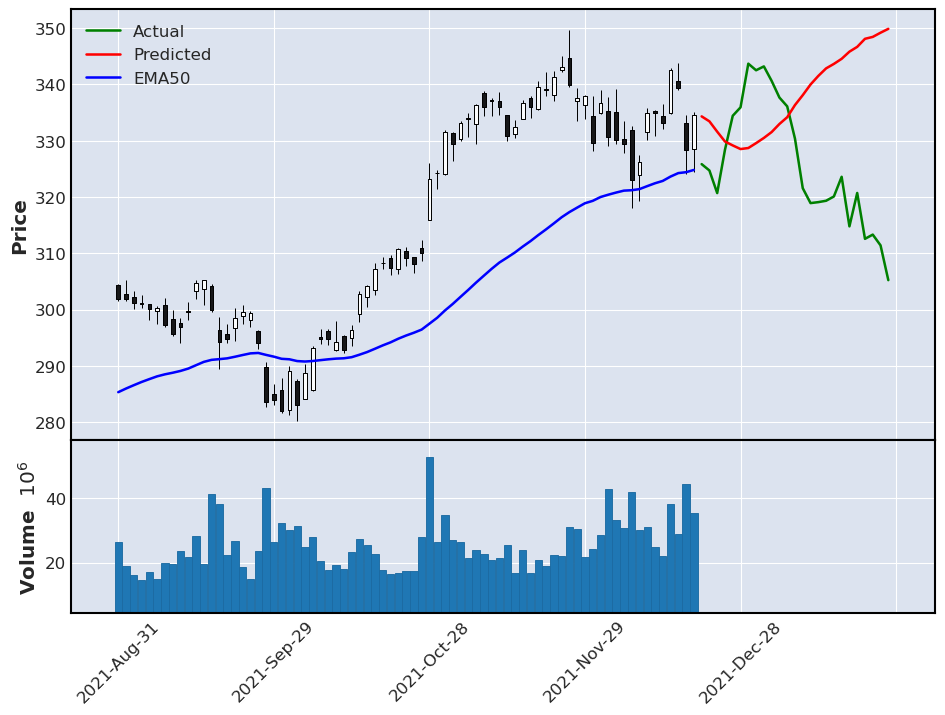

[]


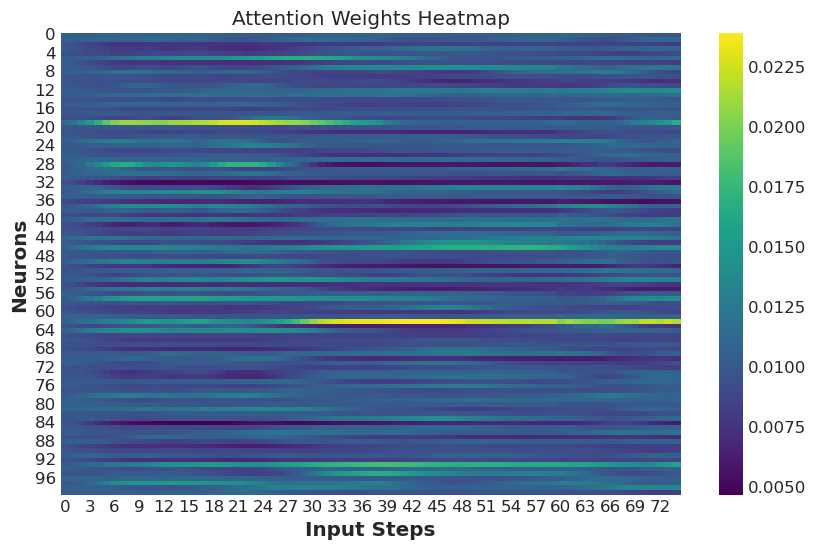

(25,)
25
DatetimeIndex(['2021-12-17', '2021-12-20'], dtype='datetime64[ns]', freq='C')


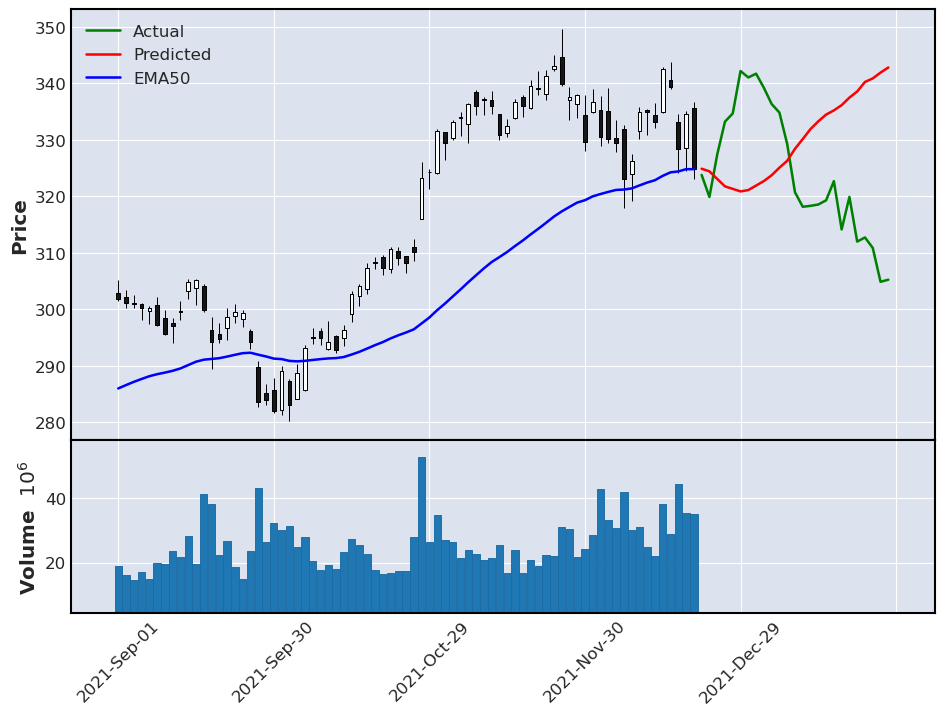

[]


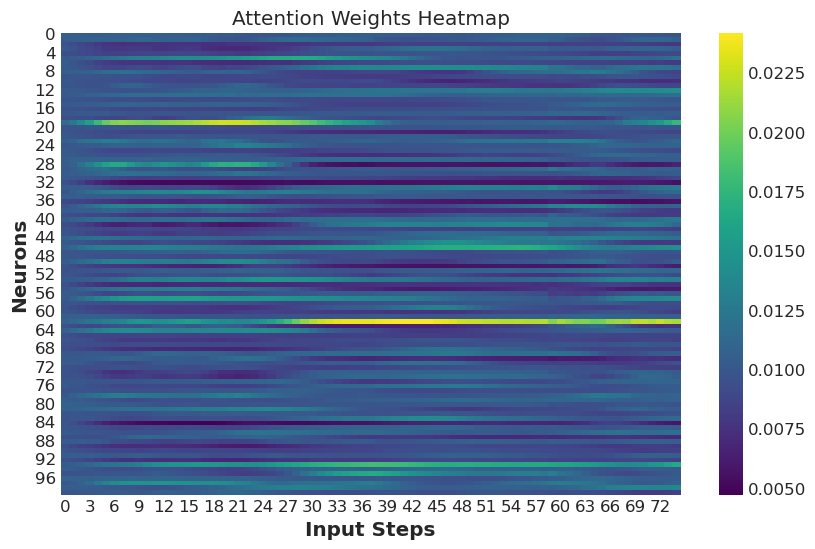

(25,)
25
DatetimeIndex(['2021-12-20', '2021-12-21'], dtype='datetime64[ns]', freq='C')


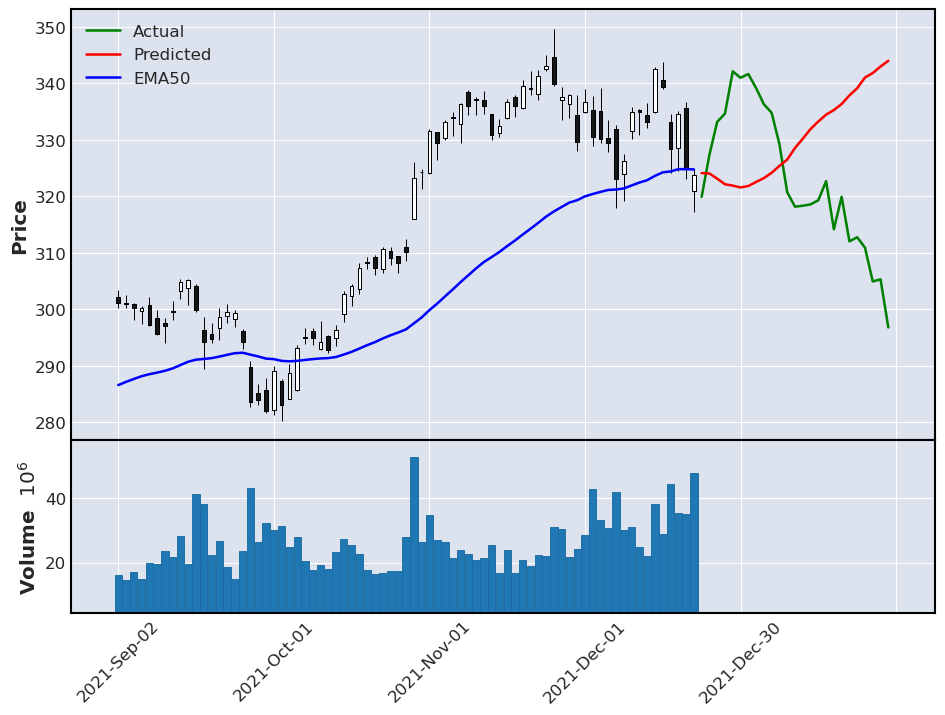

[]


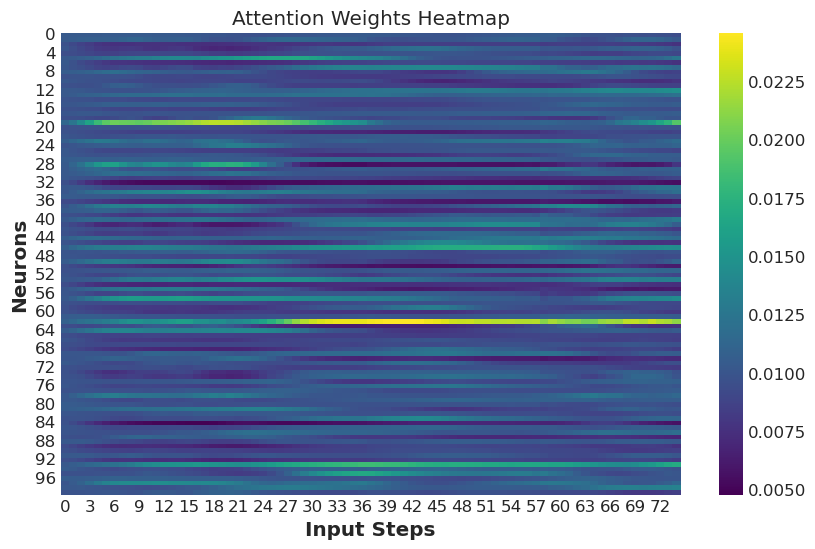

(25,)
25
DatetimeIndex(['2021-12-21', '2021-12-22'], dtype='datetime64[ns]', freq='C')


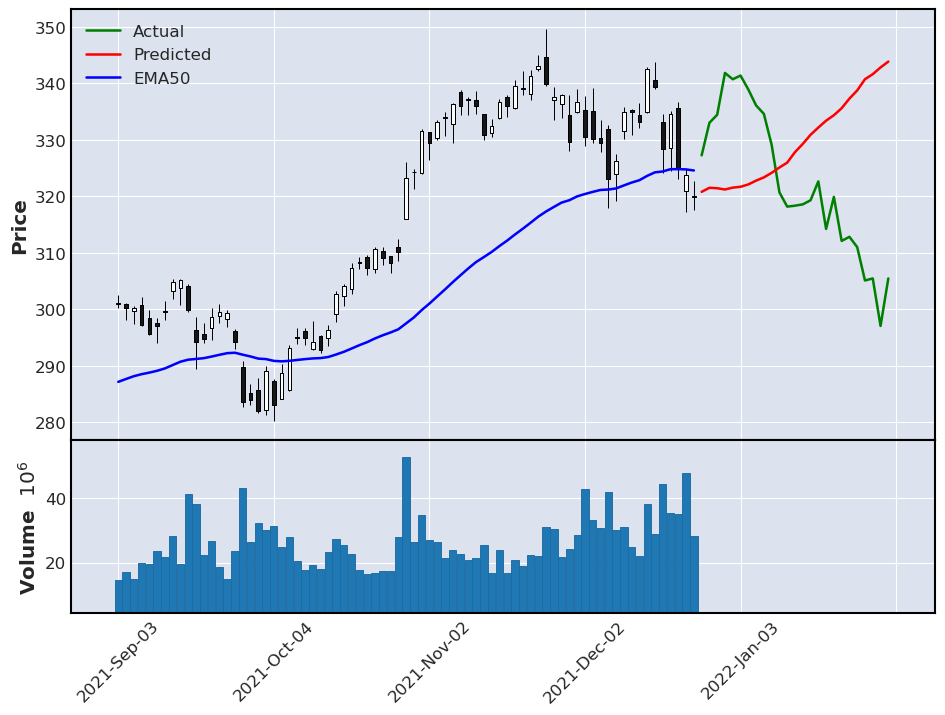

[]


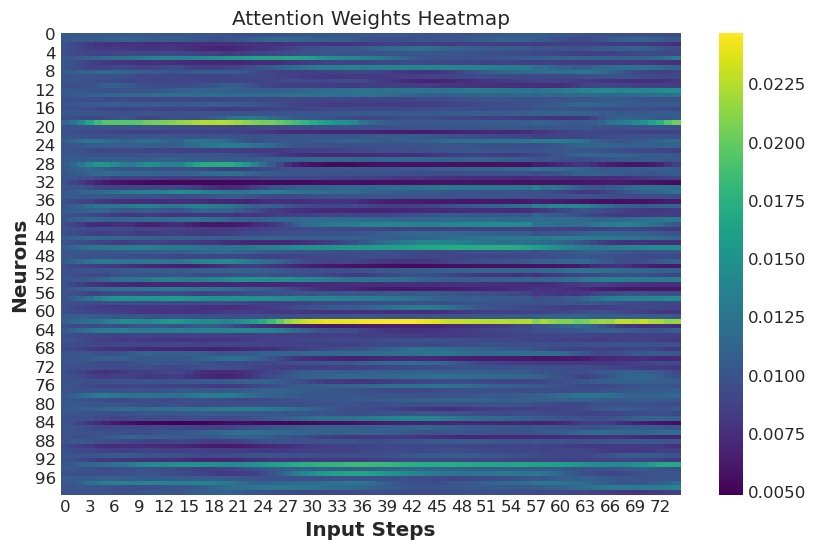

(25,)
25
DatetimeIndex(['2021-12-22', '2021-12-23'], dtype='datetime64[ns]', freq='C')


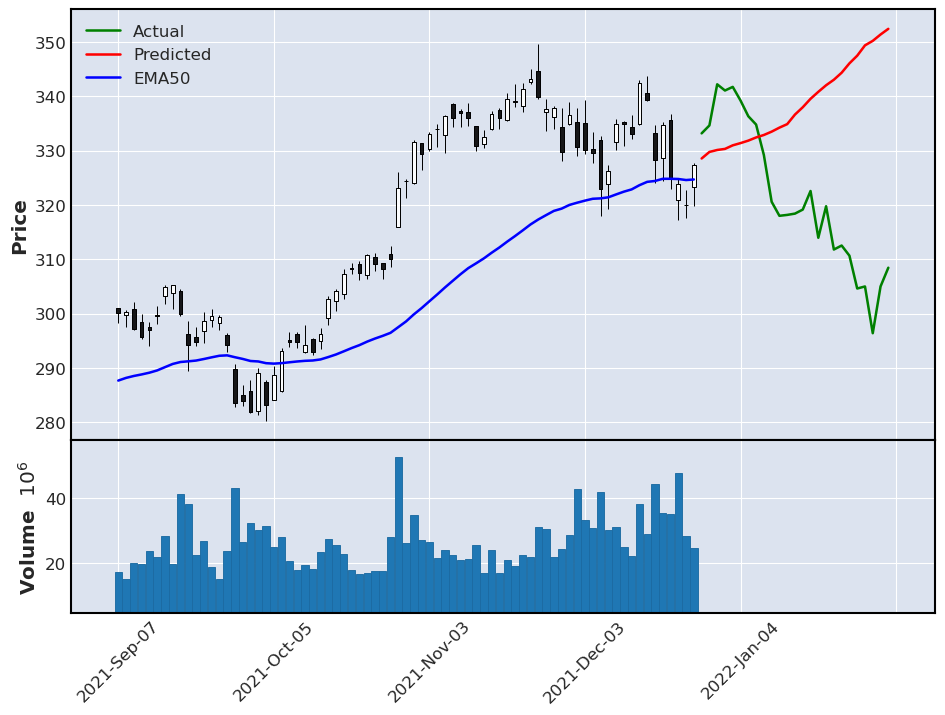

[]


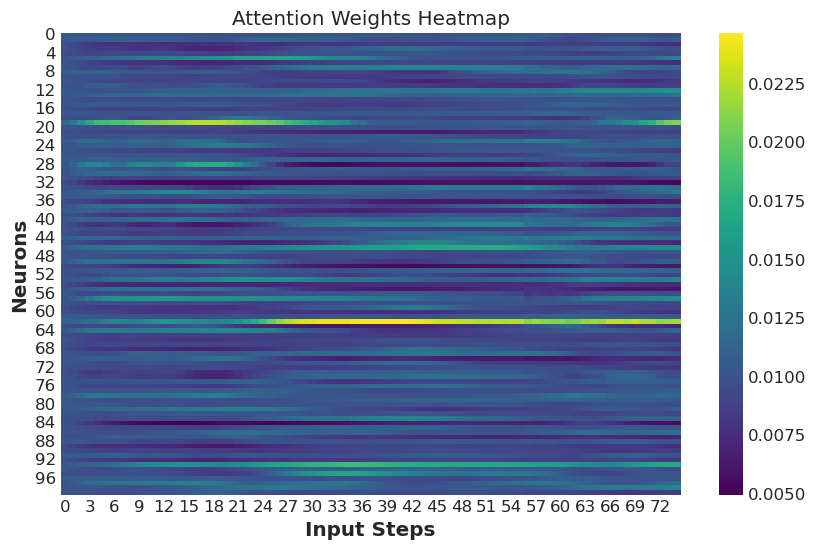

(25,)
25
DatetimeIndex(['2021-12-23', '2021-12-27'], dtype='datetime64[ns]', freq='C')


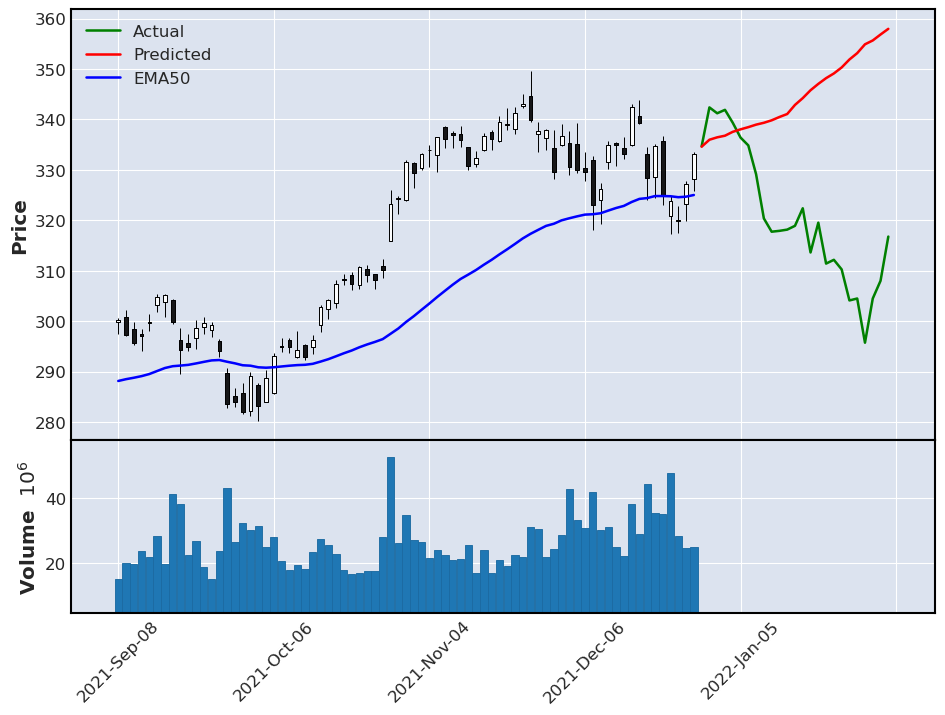

[]


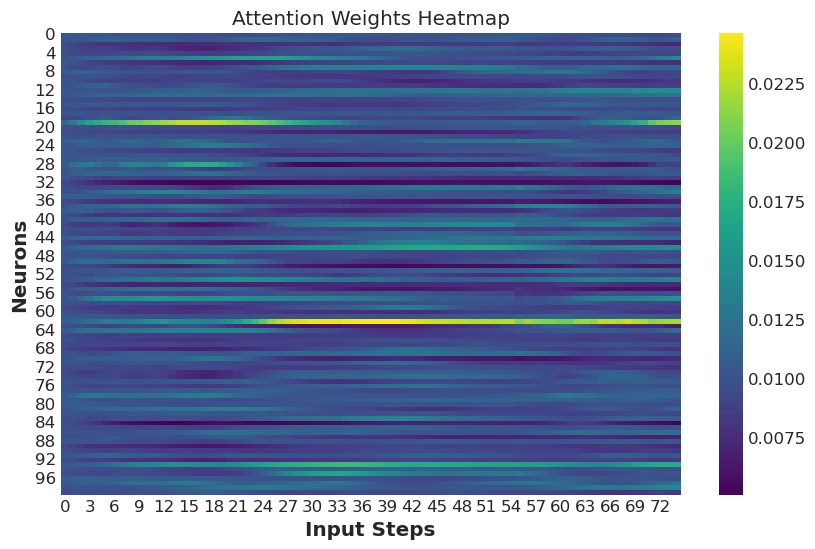

(25,)
25
DatetimeIndex(['2021-12-27', '2021-12-28'], dtype='datetime64[ns]', freq='C')


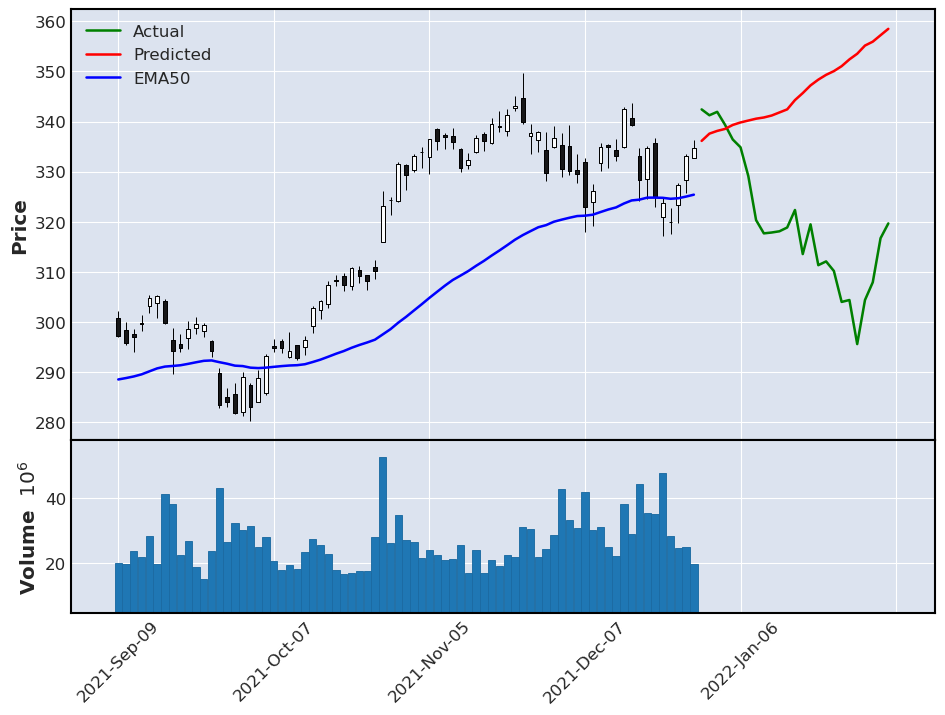

[]


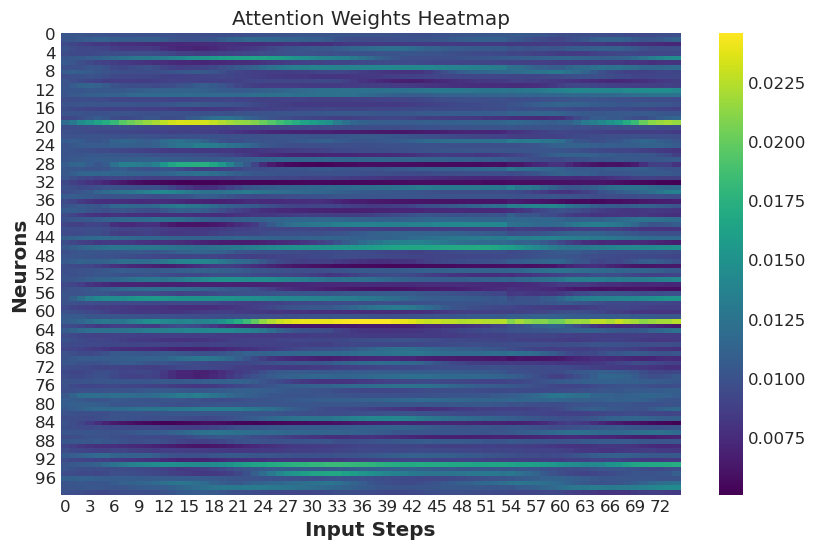

(25,)
25
DatetimeIndex(['2021-12-28', '2021-12-29'], dtype='datetime64[ns]', freq='C')


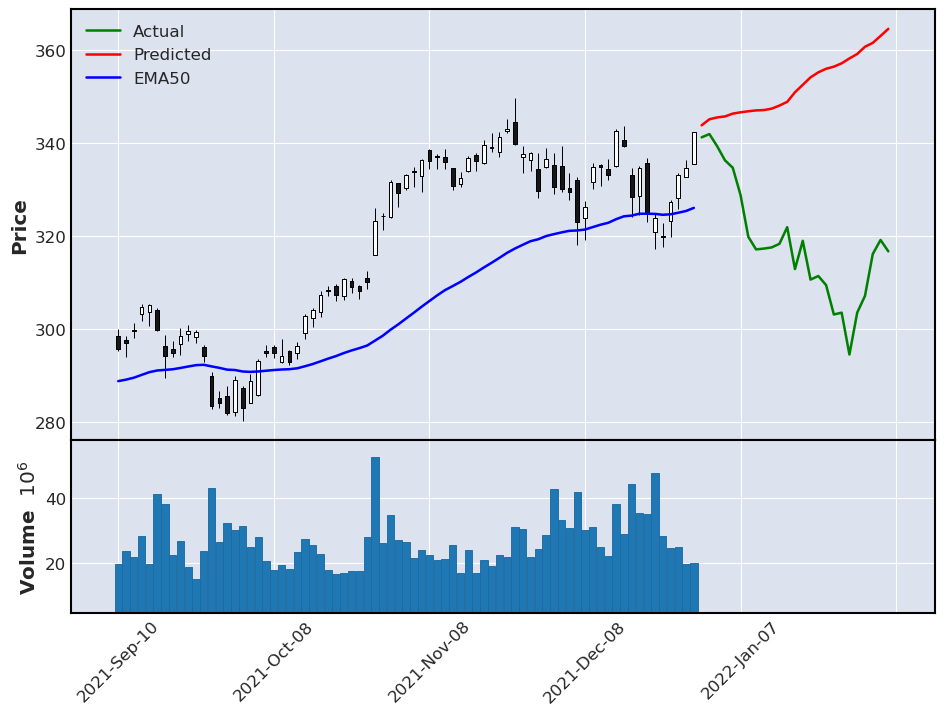

In [72]:


for i in range(100,120):
    attention_weight = attention_weights[i]
    sequence_element = cluster_of_interest.test_seq_elements[i]
    prediction = predicted_y_transformed[i]
    print(sequence_element.y_feature_sets)
    plot = test_utils.plot_attention_weights(attention_weight)
    plot.show()
    sp.SequenceElement.visualize_future_movement_mpl(sequence_element, prediction, scaler, isCuma = False, target_features=target_features, num_days=num_days)